https://machinelearningmastery.com/grid-search-data-preparation-techniques/

*An alternative approach to data preparation is to grid search a suite of common and commonly useful data preparation techniques to the raw data. This is an alternative philosophy for data preparation that treats data transforms as another hyperparameter of the modeling pipeline to be searched and tuned.*

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd

pd.set_option( 'display.max_columns' , None ) 

In [4]:
from sklearn.preprocessing import LabelEncoder

In [9]:
def load_dataset() :
    
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/wine.csv'
    
    df = pd.read_csv( url , header = None )
    
    dataset = df.values
    
    X = dataset[ : , : -1 ]
    
    y = dataset[ : , -1 ]
    
    y = LabelEncoder().fit_transform( y.astype( 'str' ) )
    
    return X , y

In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import cross_val_score

In [11]:
def evaluate_model( X , y , model ) :
    
    cv = RepeatedStratifiedKFold( n_splits = 10 , n_repeats = 3 , random_state = 999 )
    
    scores = cross_val_score( model , X , y , scoring = 'accuracy' , cv = cv , n_jobs = -1 )
    
    return scores

# Baseline Model Performance

In [12]:
X , y = load_dataset()

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
model = LogisticRegression( solver = 'liblinear' )

In [17]:
scores = evaluate_model( X , y , model )

In [19]:
from numpy import mean

from numpy import std

In [20]:
print( f'ACCURACY : {mean( scores ):.3f} ( {std( scores ):.3f} )' )

ACCURACY : 0.951 ( 0.043 )


# Grid Search Approach to Data Preparation

In [22]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import QuantileTransformer

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.decomposition import PCA

from sklearn.decomposition import TruncatedSVD

In [31]:
def get_pipelines( model ) :
    
    pipelines = list()
    
    # normalize
    
    steps = [ ('s' , MinMaxScaler() ) , 
              ( 'm' ,model ) ]
    
    p = Pipeline( steps = steps )
    
    pipelines.append( ( 'norm' , p ) )
    
    # standardize
    
    steps = [ ( 's' , StandardScaler() ) , 
              ( 'm' , model ) ]
    
    p = Pipeline( steps = steps )
    
    pipelines.append( ( 'std' , p ) )
    
    # quantile
    
    steps = [ ( 's' , QuantileTransformer( n_quantiles = 100 , output_distribution = 'normal' ) ) , 
              ( 'm' , model ) ]
    
    p = Pipeline( steps = steps )
    
    pipelines.append( ( 'quan' , p ) )
    
    # discretize
    
    steps = [ ( 's' , KBinsDiscretizer( n_bins = 10 , encode = 'ordinal' , strategy = 'uniform' ) ) ,
              ( 'm' , model ) ]
    
    p = Pipeline( steps = steps )
    
    pipelines.append( ( 'kbins' , p ) )
    
    # pca
    
    steps = [ ( 's' , PCA( n_components = 7 ) ) ,
              ( 'm' , model ) ]
    
    p = Pipeline( steps = steps )
    
    pipelines.append( ( 'pca' , p ) )
    
    # svd 
    
    steps = [ ( 's' , TruncatedSVD( n_components = 7 ) ) ,
              ( 'm' , model ) ]
    
    p = Pipeline( steps = steps )
    
    pipelines.append( ( 'svd' , p ) )
    
    
    return pipelines

In [32]:
X , y = load_dataset()

In [33]:
model = LogisticRegression( solver = 'liblinear' )

In [36]:
pipelines = get_pipelines( model )

print( pipelines )

[('norm', Pipeline(steps=[('s', MinMaxScaler()),
                ('m', LogisticRegression(solver='liblinear'))])), ('std', Pipeline(steps=[('s', StandardScaler()),
                ('m', LogisticRegression(solver='liblinear'))])), ('quan', Pipeline(steps=[('s',
                 QuantileTransformer(n_quantiles=100,
                                     output_distribution='normal')),
                ('m', LogisticRegression(solver='liblinear'))])), ('kbins', Pipeline(steps=[('s',
                 KBinsDiscretizer(encode='ordinal', n_bins=10,
                                  strategy='uniform')),
                ('m', LogisticRegression(solver='liblinear'))])), ('pca', Pipeline(steps=[('s', PCA(n_components=7)),
                ('m', LogisticRegression(solver='liblinear'))])), ('svd', Pipeline(steps=[('s', TruncatedSVD(n_components=7)),
                ('m', LogisticRegression(solver='liblinear'))]))]


In [37]:
results = list()

names = list()

for name , pipeline in pipelines :
    
    scores = evaluate_model( X , y , pipeline )
    
    print( f'{name} : {mean( scores ):.3f} ( {std( scores ):.3f} )' )
    
    results.append( scores )
    
    names.append( name )

norm : 0.975 ( 0.038 )
std : 0.983 ( 0.030 )
quan : 0.979 ( 0.034 )
kbins : 0.957 ( 0.052 )
pca : 0.961 ( 0.039 )
svd : 0.947 ( 0.044 )


In [38]:
from matplotlib import pyplot

{'whiskers': [<matplotlib.lines.Line2D at 0x1d22a5f8>,
 'caps': [<matplotlib.lines.Line2D at 0x1d22a860>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf8e9b0>,
 'medians': [<matplotlib.lines.Line2D at 0x1d22a550>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d2247f0>,
 'means': [<matplotlib.lines.Line2D at 0x1d2240f0>,
  <matplotlib.lines.Line2D at 0x1d2f2d68>]}

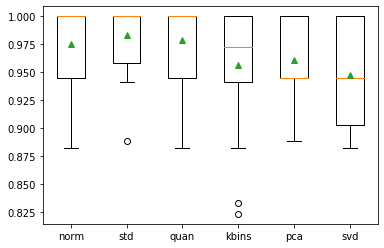

In [39]:
pyplot.boxplot( results , labels = names , showmeans = True )

pyplot.show()